In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

#Load CSV
df = pd.read_csv(
    r"E:\Masters Project\Raw Data\Raw Data Collection\Control - 1 Minute - New Environment\binOutput_IQ.csv"
)

# Determine dimensions
n_frames   = df['Frame Index'].max() + 1
n_chirps   = df['Chirp Index'].max() + 1
n_samples  = df['Sample Index'].max() + 1
n_rx       = df['Antenna Index'].max() + 1
n_tx       = 2  # assumed 1 TX since no TX info in file

#Create empty complex array [RX, Samples, TX, Chirps, Frames]
data = np.zeros((n_rx, n_samples, n_tx, n_chirps, n_frames), dtype=np.complex64)

#Fill array with the I/Q values
for row in tqdm(df.itertuples(index=False), total=len(df), desc="Loading ADC data"):
    frame    = int(row[0])
    chirp    = int(row[1])
    sample   = int(row[2])
    antenna  = int(row[3])
    i_val    = row[4]
    q_val    = row[5]

    data[antenna, sample, 0, chirp, frame] = complex(i_val, q_val)

print(f"Loaded data shape: {data.shape}")


Loading ADC data: 100%|████████████████████████████████████████████████| 18677760/18677760 [00:37<00:00, 499576.61it/s]

Loaded data shape: (6, 256, 2, 64, 190)


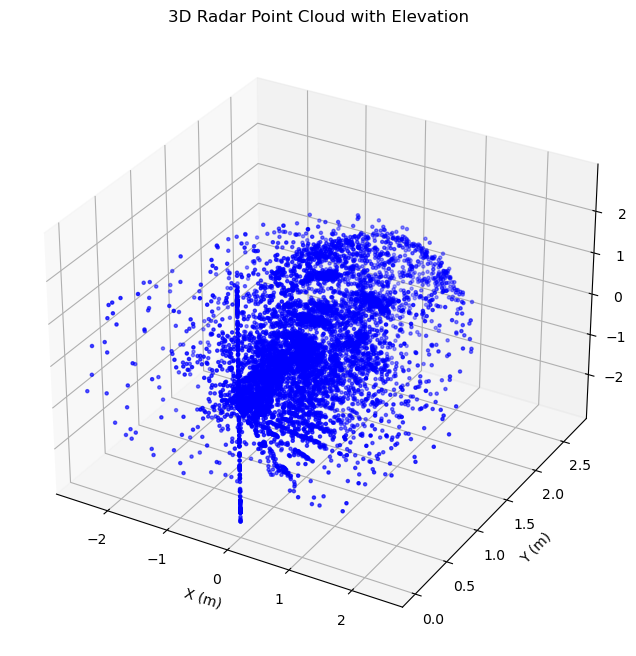

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Radar constants
c = 3e8
f_c = 60.5e9  #frequency in Hz
wavelength = c / f_c
range_resolution = 0.0214  #meters per bin
n_rx, n_samples, n_tx, n_chirps, n_frames = data.shape
n_angle_bins = 64  #resolution of FFT

#Output storage
points = []

#Process one frame and one transmitting antenna
frame = 0
tx = 0
frame_data = data[:, :, tx, :, frame]

#perform Range FFT
window = np.hanning(n_samples)
windowed_data = frame_data * window[:, np.newaxis]
range_fft = np.fft.fft(windowed_data, axis=1)
range_fft = range_fft[:, :n_samples // 2, :]

# Antenna index mapping based on your layout
# Rx1 = 0, Rx2 = 1, Rx3 = 2 --- Recieving antennas
for r in range(range_fft.shape[1]):  # range bins
    for d in range(range_fft.shape[2]):  # chirps
        signal = range_fft[:, r, d]

        if np.abs(signal).max() < 1e2:
            continue  # skip weak reflections

        rx1 = signal[0]  # horizontal
        rx2 = signal[1]  # reference
        rx3 = signal[2]  # vertical

        # --- Azimuth values from Rx2-Rx1 ---
        az_signal = np.array([rx2, rx1])
        az_fft = np.fft.fftshift(np.fft.fft(az_signal, n=n_angle_bins))
        az_mag = np.abs(az_fft)
        az_idx = np.argmax(az_mag)
        sin_theta = np.clip(np.linspace(-1, 1, n_angle_bins)[az_idx], -1, 1)
        theta = np.arcsin(sin_theta)

        # --- Elevation values from Rx2-Rx3 ---
        el_signal = np.array([rx2, rx3])
        el_fft = np.fft.fftshift(np.fft.fft(el_signal, n=n_angle_bins))
        el_mag = np.abs(el_fft)
        el_idx = np.argmax(el_mag)
        sin_phi = np.clip(np.linspace(-1, 1, n_angle_bins)[el_idx], -1, 1)
        phi = np.arcsin(sin_phi)

        # Convert to Cartesian coordinates
        rng = r * range_resolution
        x = rng * np.cos(phi) * np.sin(theta)
        y = rng * np.cos(phi) * np.cos(theta)
        z = rng * np.sin(phi)

        points.append([x, y, z])

# Convert to points and plot
points = np.array(points)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='blue', s=5)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Radar Point Cloud with Elevation')
plt.show()


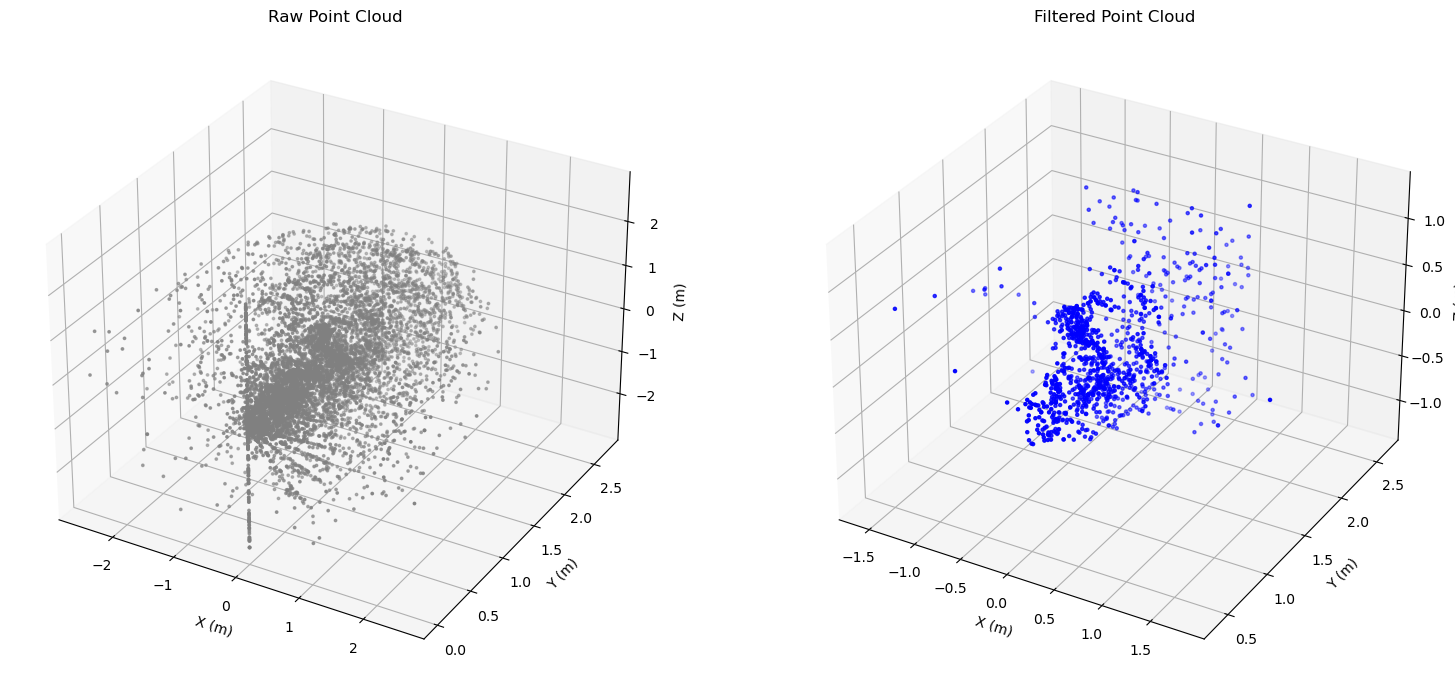

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Radar constants
c = 3e8
f_c = 60.5e9
wavelength = c / f_c
range_resolution = 0.0214
n_rx, n_samples, n_tx, n_chirps, n_frames = data.shape
n_angle_bins = 64

# Output storage
points_raw = []
points_filtered = []

# Use first TX, first frame
frame_data = data[:, :, 0, :, 100]

# Range FFT
window = np.hanning(n_samples)
windowed_data = frame_data * window[:, np.newaxis]
range_fft = np.fft.fft(windowed_data, axis=1)
range_fft = range_fft[:, :n_samples // 2, :]

# Angle grid
angle_grid = np.linspace(-1, 1, n_angle_bins)

for r in range(range_fft.shape[1]):
    for d in range(range_fft.shape[2]):
        signal = range_fft[:, r, d]

        if np.abs(signal).max() < 1e2:
            continue

        rx1, rx2, rx3 = signal[0], signal[1], signal[2]

        # Azimuth
        az_signal = np.array([rx2, rx1])
        az_fft = np.fft.fftshift(np.fft.fft(az_signal, n=n_angle_bins))
        az_mag = np.abs(az_fft)
        az_idx = np.argmax(az_mag)
        az_peak = az_mag[az_idx]
        sin_theta = np.clip(angle_grid[az_idx], -1, 1)
        theta = np.arcsin(sin_theta)

        # Elevation
        el_signal = np.array([rx2, rx3])
        el_fft = np.fft.fftshift(np.fft.fft(el_signal, n=n_angle_bins))
        el_mag = np.abs(el_fft)
        el_idx = np.argmax(el_mag)
        el_peak = el_mag[el_idx]
        sin_phi = np.clip(angle_grid[el_idx], -1, 1)
        phi = np.arcsin(sin_phi)

        rng = r * range_resolution
        x = rng * np.cos(phi) * np.sin(theta)
        y = rng * np.cos(phi) * np.cos(theta)
        z = rng * np.sin(phi)

        #append raw points
        points_raw.append([x, y, z])

        #applying thresholding
        if az_peak < 25000 or el_peak < 25000:
            continue
        if rng < 0.5 or rng > 10:
            continue
        if abs(theta) > np.radians(70) or abs(phi) > np.radians(30):
            continue

        #Append filtered points 
        points_filtered.append([x, y, z])

points_raw = np.array(points_raw)
points_filtered = np.array(points_filtered)

# Plot:raw vs filtered point clouds
fig = plt.figure(figsize=(16, 7))

#Raw point cloud
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points_raw[:, 0], points_raw[:, 1], points_raw[:, 2], c='gray', s=3)
ax1.set_title("Raw Point Cloud")
ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")
ax1.set_zlabel("Z (m)")

#Filtered point cloud
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points_filtered[:, 0], points_filtered[:, 1], points_filtered[:, 2], c='blue', s=5)
ax2.set_title("Filtered Point Cloud")
ax2.set_xlabel("X (m)")
ax2.set_ylabel("Y (m)")
ax2.set_zlabel("Z (m)")

plt.tight_layout()
plt.show()


In [8]:
angle_grid = np.linspace(-1, 1, n_angle_bins)

no_presence_pointclouds = []  
frame_indices = range(20, 120)  # Middle 100 frames

for frame_id in frame_indices:
    points_filtered = []

    frame_data = data[:, :, 0, :, frame_id]
    window = np.hanning(n_samples)
    windowed_data = frame_data * window[:, np.newaxis]
    range_fft = np.fft.fft(windowed_data, axis=1)
    range_fft = range_fft[:, :n_samples // 2, :]
    
    for r in range(range_fft.shape[1]):
        for d in range(range_fft.shape[2]):
            signal = range_fft[:, r, d]

            if np.abs(signal).max() < 1e2:
                continue

            rx1, rx2, rx3 = signal[0], signal[1], signal[2]

            # Azimuth
            az_signal = np.array([rx2, rx1])
            az_fft = np.fft.fftshift(np.fft.fft(az_signal, n=n_angle_bins))
            az_mag = np.abs(az_fft)
            az_idx = np.argmax(az_mag)
            az_peak = az_mag[az_idx]
            sin_theta = np.clip(angle_grid[az_idx], -1, 1)
            theta = np.arcsin(sin_theta)

            # Elevation
            el_signal = np.array([rx2, rx3])
            el_fft = np.fft.fftshift(np.fft.fft(el_signal, n=n_angle_bins))
            el_mag = np.abs(el_fft)
            el_idx = np.argmax(el_mag)
            el_peak = el_mag[el_idx]
            sin_phi = np.clip(angle_grid[el_idx], -1, 1)
            phi = np.arcsin(sin_phi)

            rng = r * range_resolution
            x = rng * np.cos(phi) * np.sin(theta)
            y = rng * np.cos(phi) * np.cos(theta)
            z = rng * np.sin(phi)

            #applying thresholding
            if az_peak < 25000 or el_peak < 25000:
                continue
            if rng < 0.5 or rng > 10:
                continue
            if abs(theta) > np.radians(70) or abs(phi) > np.radians(30):
                continue

            #Append filtered points 
            points_filtered.append([x, y, z])
            
    no_presence_pointclouds.append(np.array(points_filtered))

print(f"Stored {len(no_presence_pointclouds)} filtered point clouds for no-presence frames.")

Stored 100 filtered point clouds for no-presence frames.


In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm

#Load CSV
df = pd.read_csv(
    r"E:\Masters Project\Raw Data\Raw Data Collection\Subject 1 - Run 1 - Sitting - 4 Minutes\binOutput_IQ.csv"
)

# Determine dimensions
n_frames   = df['Frame Index'].max() + 1
n_chirps   = df['Chirp Index'].max() + 1
n_samples  = df['Sample Index'].max() + 1
n_rx       = df['Antenna Index'].max() + 1
n_tx       = 2  # assumed 1 TX since no TX info in file

#Create empty complex array [RX, Samples, TX, Chirps, Frames]
data = np.zeros((n_rx, n_samples, n_tx, n_chirps, n_frames), dtype=np.complex64)

#Fill array with the I/Q values
for row in tqdm(df.itertuples(index=False), total=len(df), desc="Loading ADC data"):
    frame    = int(row[0])
    chirp    = int(row[1])
    sample   = int(row[2])
    antenna  = int(row[3])
    i_val    = row[4]
    q_val    = row[5]

    data[antenna, sample, 0, chirp, frame] = complex(i_val, q_val)

print(f"Loaded data shape: {data.shape}")


import numpy as np
import matplotlib.pyplot as plt

# Radar constants
c = 3e8
f_c = 60.5e9
wavelength = c / f_c
range_resolution = 0.0214
n_rx, n_samples, n_tx, n_chirps, n_frames = data.shape
n_angle_bins = 64

# Output storage
points_raw = []
points_filtered = []

# Use first TX, first frame
frame_data = data[:, :, 0, :, 100]

# Range FFT
window = np.hanning(n_samples)
windowed_data = frame_data * window[:, np.newaxis]
range_fft = np.fft.fft(windowed_data, axis=1)
range_fft = range_fft[:, :n_samples // 2, :]

# Angle grid
angle_grid = np.linspace(-1, 1, n_angle_bins)

for r in range(range_fft.shape[1]):
    for d in range(range_fft.shape[2]):
        signal = range_fft[:, r, d]

        if np.abs(signal).max() < 1e2:
            continue

        rx1, rx2, rx3 = signal[0], signal[1], signal[2]

        # Azimuth
        az_signal = np.array([rx2, rx1])
        az_fft = np.fft.fftshift(np.fft.fft(az_signal, n=n_angle_bins))
        az_mag = np.abs(az_fft)
        az_idx = np.argmax(az_mag)
        az_peak = az_mag[az_idx]
        sin_theta = np.clip(angle_grid[az_idx], -1, 1)
        theta = np.arcsin(sin_theta)

        # Elevation
        el_signal = np.array([rx2, rx3])
        el_fft = np.fft.fftshift(np.fft.fft(el_signal, n=n_angle_bins))
        el_mag = np.abs(el_fft)
        el_idx = np.argmax(el_mag)
        el_peak = el_mag[el_idx]
        sin_phi = np.clip(angle_grid[el_idx], -1, 1)
        phi = np.arcsin(sin_phi)

        rng = r * range_resolution
        x = rng * np.cos(phi) * np.sin(theta)
        y = rng * np.cos(phi) * np.cos(theta)
        z = rng * np.sin(phi)

        #append raw points
        points_raw.append([x, y, z])

        #applying thresholding
        if az_peak < 25000 or el_peak < 25000:
            continue
        if rng < 0.5 or rng > 10:
            continue
        if abs(theta) > np.radians(70) or abs(phi) > np.radians(30):
            continue

        #Append filtered points 
        points_filtered.append([x, y, z])

points_raw = np.array(points_raw)
points_filtered = np.array(points_filtered)

# Plot:raw vs filtered point clouds
fig = plt.figure(figsize=(16, 7))

#Raw point cloud
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points_raw[:, 0], points_raw[:, 1], points_raw[:, 2], c='gray', s=3)
ax1.set_title("Raw Point Cloud")
ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")
ax1.set_zlabel("Z (m)")

#Filtered point cloud
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points_filtered[:, 0], points_filtered[:, 1], points_filtered[:, 2], c='blue', s=5)
ax2.set_title("Filtered Point Cloud")
ax2.set_xlabel("X (m)")
ax2.set_ylabel("Y (m)")
ax2.set_zlabel("Z (m)")

plt.tight_layout()
plt.show()

angle_grid = np.linspace(-1, 1, n_angle_bins)

presence_pointclouds = []  
frame_indices = range(200, 300)  # Adjust as needed

for frame_id in frame_indices:
    try:
        # ✅ Skip if frame_id is out of bounds
        if frame_id >= data.shape[4]:
            print(f"Skipping frame {frame_id}: out of bounds")
            continue

        points_filtered = []

        frame_data = data[:, :, 0, :, frame_id]
        window = np.hanning(n_samples)
        windowed_data = frame_data * window[:, np.newaxis]
        range_fft = np.fft.fft(windowed_data, axis=1)
        range_fft = range_fft[:, :n_samples // 2, :]

        for r in range(range_fft.shape[1]):
            for d in range(range_fft.shape[2]):
                signal = range_fft[:, r, d]

                if np.abs(signal).max() < 1e2:
                    continue

                rx1, rx2, rx3 = signal[0], signal[1], signal[2]

                az_signal = np.array([rx2, rx1])
                az_fft = np.fft.fftshift(np.fft.fft(az_signal, n=n_angle_bins))
                az_mag = np.abs(az_fft)
                az_idx = np.argmax(az_mag)
                az_peak = az_mag[az_idx]
                sin_theta = np.clip(angle_grid[az_idx], -1, 1)
                theta = np.arcsin(sin_theta)

                el_signal = np.array([rx2, rx3])
                el_fft = np.fft.fftshift(np.fft.fft(el_signal, n=n_angle_bins))
                el_mag = np.abs(el_fft)
                el_idx = np.argmax(el_mag)
                el_peak = el_mag[el_idx]
                sin_phi = np.clip(angle_grid[el_idx], -1, 1)
                phi = np.arcsin(sin_phi)

                rng = r * range_resolution
                x = rng * np.cos(phi) * np.sin(theta)
                y = rng * np.cos(phi) * np.cos(theta)
                z = rng * np.sin(phi)

                if az_peak < 25000 or el_peak < 25000:
                    continue
                if rng < 0.5 or rng > 10:
                    continue
                if abs(theta) > np.radians(70) or abs(phi) > np.radians(30):
                    continue

                points_filtered.append([x, y, z])

        presence_pointclouds.append(np.array(points_filtered))

    except Exception as e:
        print(f"Skipping frame {frame_id} due to error: {e}")
        continue

print(f"Stored {len(presence_pointclouds)} filtered point clouds for presence frames.")

MemoryError: Unable to allocate 2.51 GiB for an array with shape (6, 56229888) and data type int64